## Looking into ways of doing network analyses in python
#### Getting inspiration from:
- Borsboom, D., Deserno, M. K., Rhemtulla, M., Epskamp, S., Fried, E. I., McNally, R. J., ... & Waldorp, L. J. (2021). Network analysis of multivariate data in psychological science. Nature Reviews Methods Primers, 1(1), 1-18. https://www.nature.com/articles/s43586-021-00055-w
- https://eiko-fried.com/wp-content/uploads/Primer_s43586-021-00055-w_1629381676_1.pdf

In [1]:
import os
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info
import pingouin as pg
from itertools import combinations, product
# from pymer4 import Lmer
from scipy import signal
# from sklearn.covariance import GraphicalLasso
from gglasso.problem import glasso_problem
from typing import Union

In [2]:
current_wd = os.getcwd()

In [3]:
os.chdir(current_wd.split("playground")[0])
from jmspack.utils import JmsColors
from jmspack.frequentist_statistics import correlation_analysis
os.chdir(current_wd)

In [4]:
session_info.show(req_file_name="network-requirements.txt",
                  write_req_file=False)

In [5]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [6]:
df = sns.load_dataset(name="brain_networks").loc[3:].astype(float)
df.head()

,network,1,1.1,2,2.1,3,3.1,4,4.1,5,...,16.5,16.6,16.7,17,17.1,17.2,17.3,17.4,17.5,17.6
3,0.0,56.055744,92.031036,3.391576,38.659683,26.203819,-49.715569,47.461037,26.746613,-35.898861,...,0.607904,-70.270546,77.365776,-21.734550,1.028253,7.791784,68.903725,-10.520872,120.490463,-39.686432
4,1.0,55.547253,43.690075,-65.495987,-13.974523,-28.274963,-39.050129,-1.210660,-19.012897,19.568010,...,57.495071,-76.393219,127.261360,-13.035799,46.381824,-15.752450,31.000332,-39.607521,24.764011,-36.771008
5,2.0,60.997768,63.438793,-51.108582,-13.561346,-18.842947,-1.214659,-65.575806,-85.777428,19.247454,...,28.317369,9.063977,45.493263,26.033442,34.212200,1.326110,-22.580757,12.985169,-75.027451,6.434262
6,3.0,18.514868,12.657158,-34.576603,-32.665958,-7.420454,17.119448,-41.800869,-58.610184,32.896915,...,71.439629,65.842979,-10.697547,55.297466,4.255006,-2.420144,12.098393,-15.819172,-37.361431,-4.650954
7,4.0,-2.527392,-63.104668,-13.814151,-15.837989,-45.216927,3.483550,-62.613335,-49.076508,18.396759,...,95.597565,50.960453,-23.197300,43.067562,52.219875,28.232882,-11.719750,5.453649,5.169828,87.809135


In [7]:
cor_df = correlation_analysis(data=df.drop("network", axis=1))["summary"].round(3)
cor_df.head()

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Pearson,1,1.1,0.882,0.000,True,920
1,Pearson,1,2,-0.043,0.196,False,920
2,Pearson,1,2.1,-0.074,0.024,True,920
3,Pearson,1,3,-0.343,0.000,True,920
4,Pearson,1,3.1,-0.169,0.000,True,920


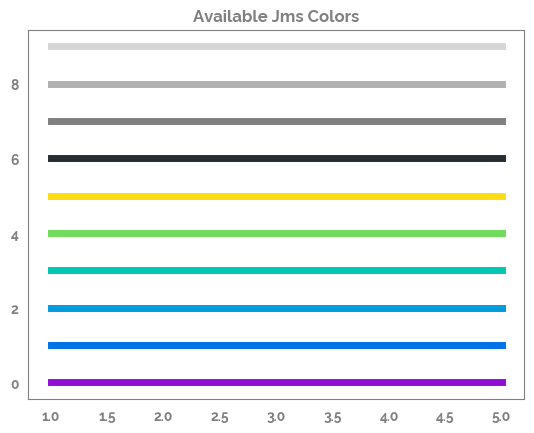

In [8]:
JmsColors.plot_colors()

### Regular correlation network

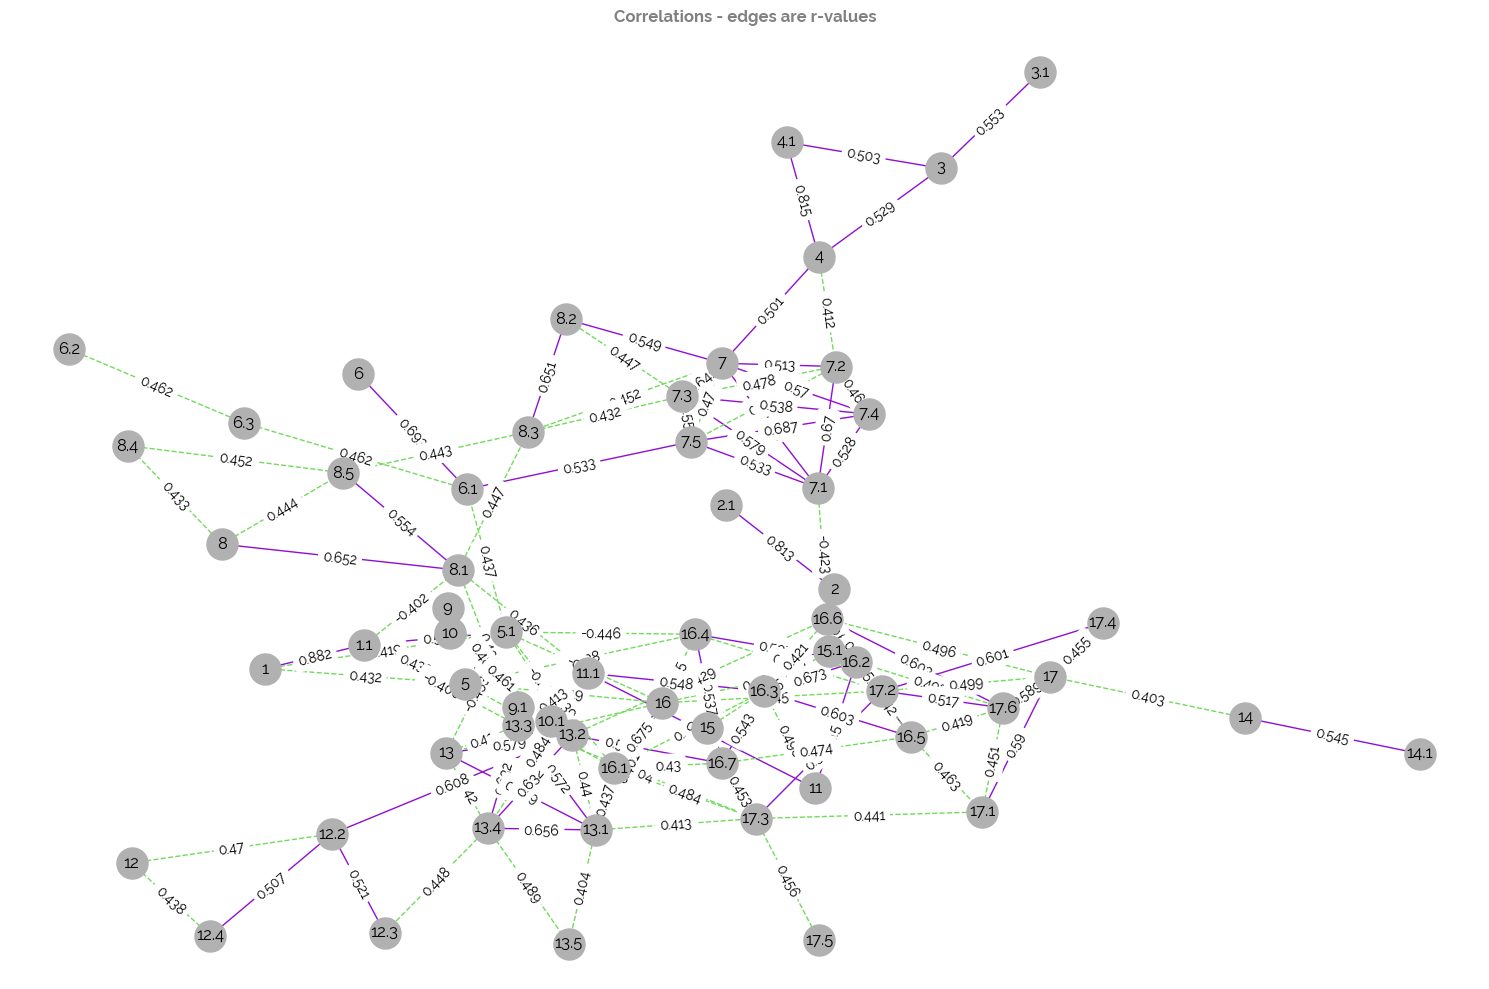

In [10]:
fig, ax = network_plot(data=cor_df)

### Partial correlation network

In [11]:
feature_list = df.drop("network", axis=1).columns.tolist()
feature_tuple_list = list(combinations(feature_list, 2))

partial_cor_df = pd.DataFrame()
for feature_tuple in feature_tuple_list:
    covariate_list = list(set(feature_list) - set(feature_tuple))
    partial_cor_df = pd.concat([partial_cor_df, 
                                pg.partial_corr(data=df, 
                                                x=feature_tuple[0], 
                                                y=feature_tuple[1], 
                                                covar=covariate_list, 
                                                method="pearson")
                                .assign(**{"feature1": feature_tuple[0], "feature2": feature_tuple[1]})
                                ])
    
partial_cor_df = partial_cor_df.rename(columns={"r": "r-value", "p-val": "p-value"}).round(3)

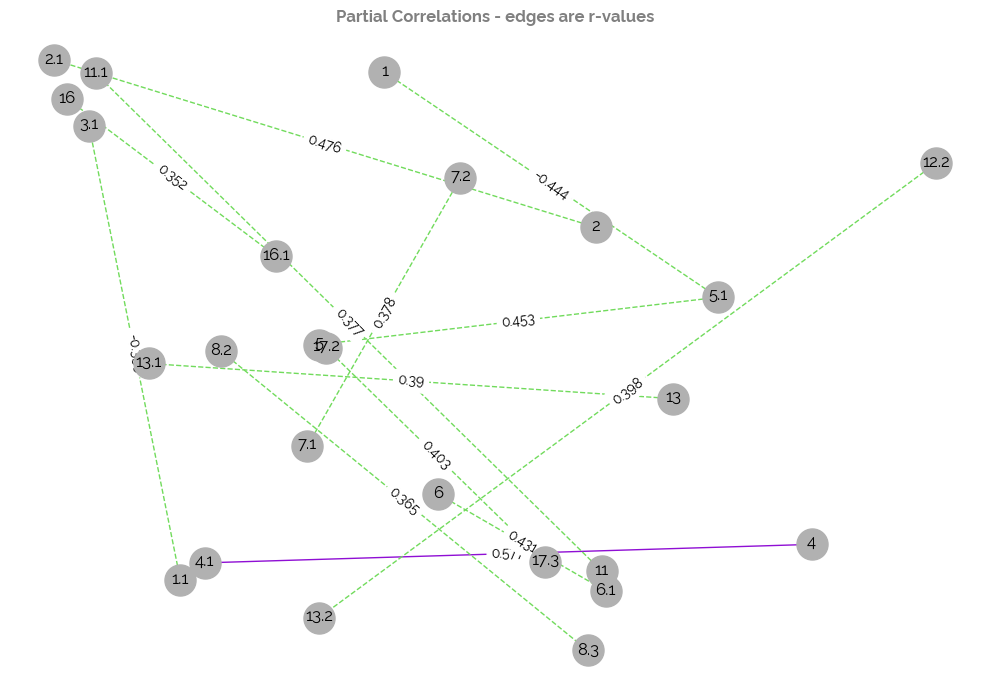

In [12]:
fig, ax = network_plot(data=partial_cor_df, 
                       edge_drop_cutoff=0.35, 
                       plot_title="Partial Correlations - edges are r-values",
                       layout="random",
                       figsize=(10, 7))

### Sparse Inverse Covariance network (Glasso)

In [13]:
# cov = GraphicalLasso().fit(df.drop("network", axis=1))

### Covariance network

In [14]:
covariance_df = (df
                 .drop("network", axis=1)
                 .cov()
 .round(2)
 .stack()
 .reset_index()
 .rename(columns={"level_0": "feature1", "level_1": "feature2", 0: "covariance"})
 )
covariance_df.head()

,feature1,feature2,covariance
0,1,1,2391.83
1,1,1.1,2301.72
2,1,2,-82.19
3,1,2.1,-154.60
4,1,3,-436.15


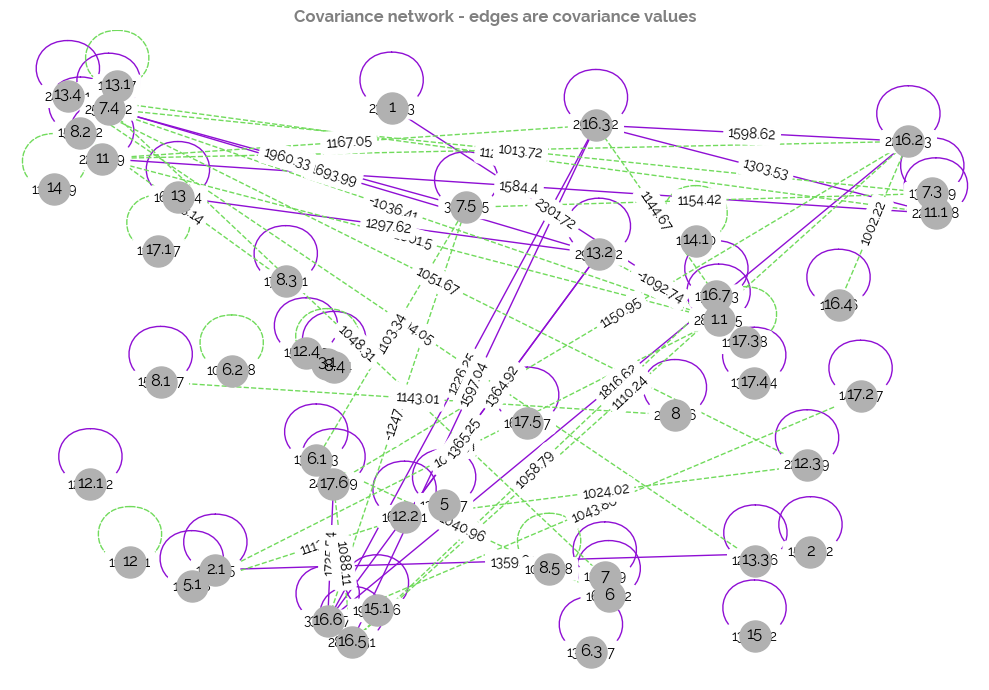

In [15]:
fig, ax = network_plot(data=covariance_df, 
                       edge_drop_cutoff=1000, 
                       edge_color_cutoff=1200,
                       edge_feature="covariance",
                       plot_title="Covariance network - edges are covariance values",
                       layout="random",
                       figsize=(10, 7))

### Graphical Lasso network (Glasso; using `EBIC`)

In [16]:
covariance_matrix = df.drop("network", axis=1).cov().values

In [17]:
model = glasso_problem(covariance_matrix, covariance_matrix.shape[0], reg_params = {'lambda1': 0.05}, latent = False, do_scaling = False)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [22]:
lambda1_range = np.logspace(0, -3, 30)
modelselect_params = {'lambda1_range': lambda1_range}

model.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1)

NameError: name 'model' is not defined

In [23]:
# regularization parameters are set to the best ones found during model selection
print(model.reg_params)

NameError: name 'model' is not defined

In [24]:
eBIC_glasso_adj_df = (pd.DataFrame(model.solution.adjacency_, 
              columns=df.drop("network", axis=1).columns, 
              index=df.drop("network", axis=1).columns)
 .stack()
 .reset_index()
 .rename(columns={"level_0": "feature1", "level_1": "feature2", 0: "adjaceny_value"})
 )

NameError: name 'model' is not defined

In [25]:
eBIC_glasso_adj_df.head()

NameError: name 'eBIC_glasso_adj_df' is not defined

In [26]:
# eBIC_glasso_df = pd.DataFrame(model.solution.adjacency_)
# _ = sns.heatmap(pd.DataFrame(model.solution.precision_))
fig, ax = network_plot(data=eBIC_glasso_adj_df, 
                       edge_drop_cutoff=0.9, 
                       edge_color_cutoff=0.9,
                       edge_feature="adjaceny_value",
                       plot_title="eBIC glasso - edges are adjency values",
                       layout="random",
                       figsize=(10, 7))

NameError: name 'eBIC_glasso_adj_df' is not defined

In [27]:
eBIC_glasso_prec_df = (pd.DataFrame(model.solution.precision_, 
              columns=df.drop("network", axis=1).columns, 
              index=df.drop("network", axis=1).columns)
 .round(4)
 .stack()
 .reset_index()
 .rename(columns={"level_0": "feature1", "level_1": "feature2", 0: "adjaceny_value"})
 )
eBIC_glasso_prec_df.head()

NameError: name 'model' is not defined

In [28]:
fig, ax = network_plot(data=eBIC_glasso_prec_df, 
                       edge_drop_cutoff=0.001, 
                       edge_color_cutoff=0.0002,
                       edge_feature="adjaceny_value",
                       plot_title="eBIC glasso - edges are precision values",
                       layout="random",
                       figsize=(10, 7))

NameError: name 'eBIC_glasso_prec_df' is not defined